# Multidimensional scaling

Some notes I've discovered during my search for Instagram user distance.

Visualisations based on https://www.de.dariah.eu/tatom/working_with_text.html#visualizing-distances.


In [1]:
import psycopg2
import psycopg2.extras

import psycopg2.extensions
psycopg2.extensions.register_type(psycopg2.extensions.UNICODE)
psycopg2.extensions.register_type(psycopg2.extensions.UNICODEARRAY)

conn = psycopg2.connect("dbname=instagram_lda user=pc")
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

cur.execute("SELECT raw_text, username FROM media")
data = cur.fetchall()
media = map(lambda i: i[0], data)
usernames = map(lambda i: i[1], data)

### Generate document-term matrix

In [2]:
import numpy as np # a conventional alias

import sklearn.feature_extraction.text as text

vectorizer = text.CountVectorizer(input='content', strip_accents='ascii', stop_words='english', min_df=20)

dtm = vectorizer.fit_transform(media).toarray()

vocab = np.array(vectorizer.get_feature_names())

### user similarity

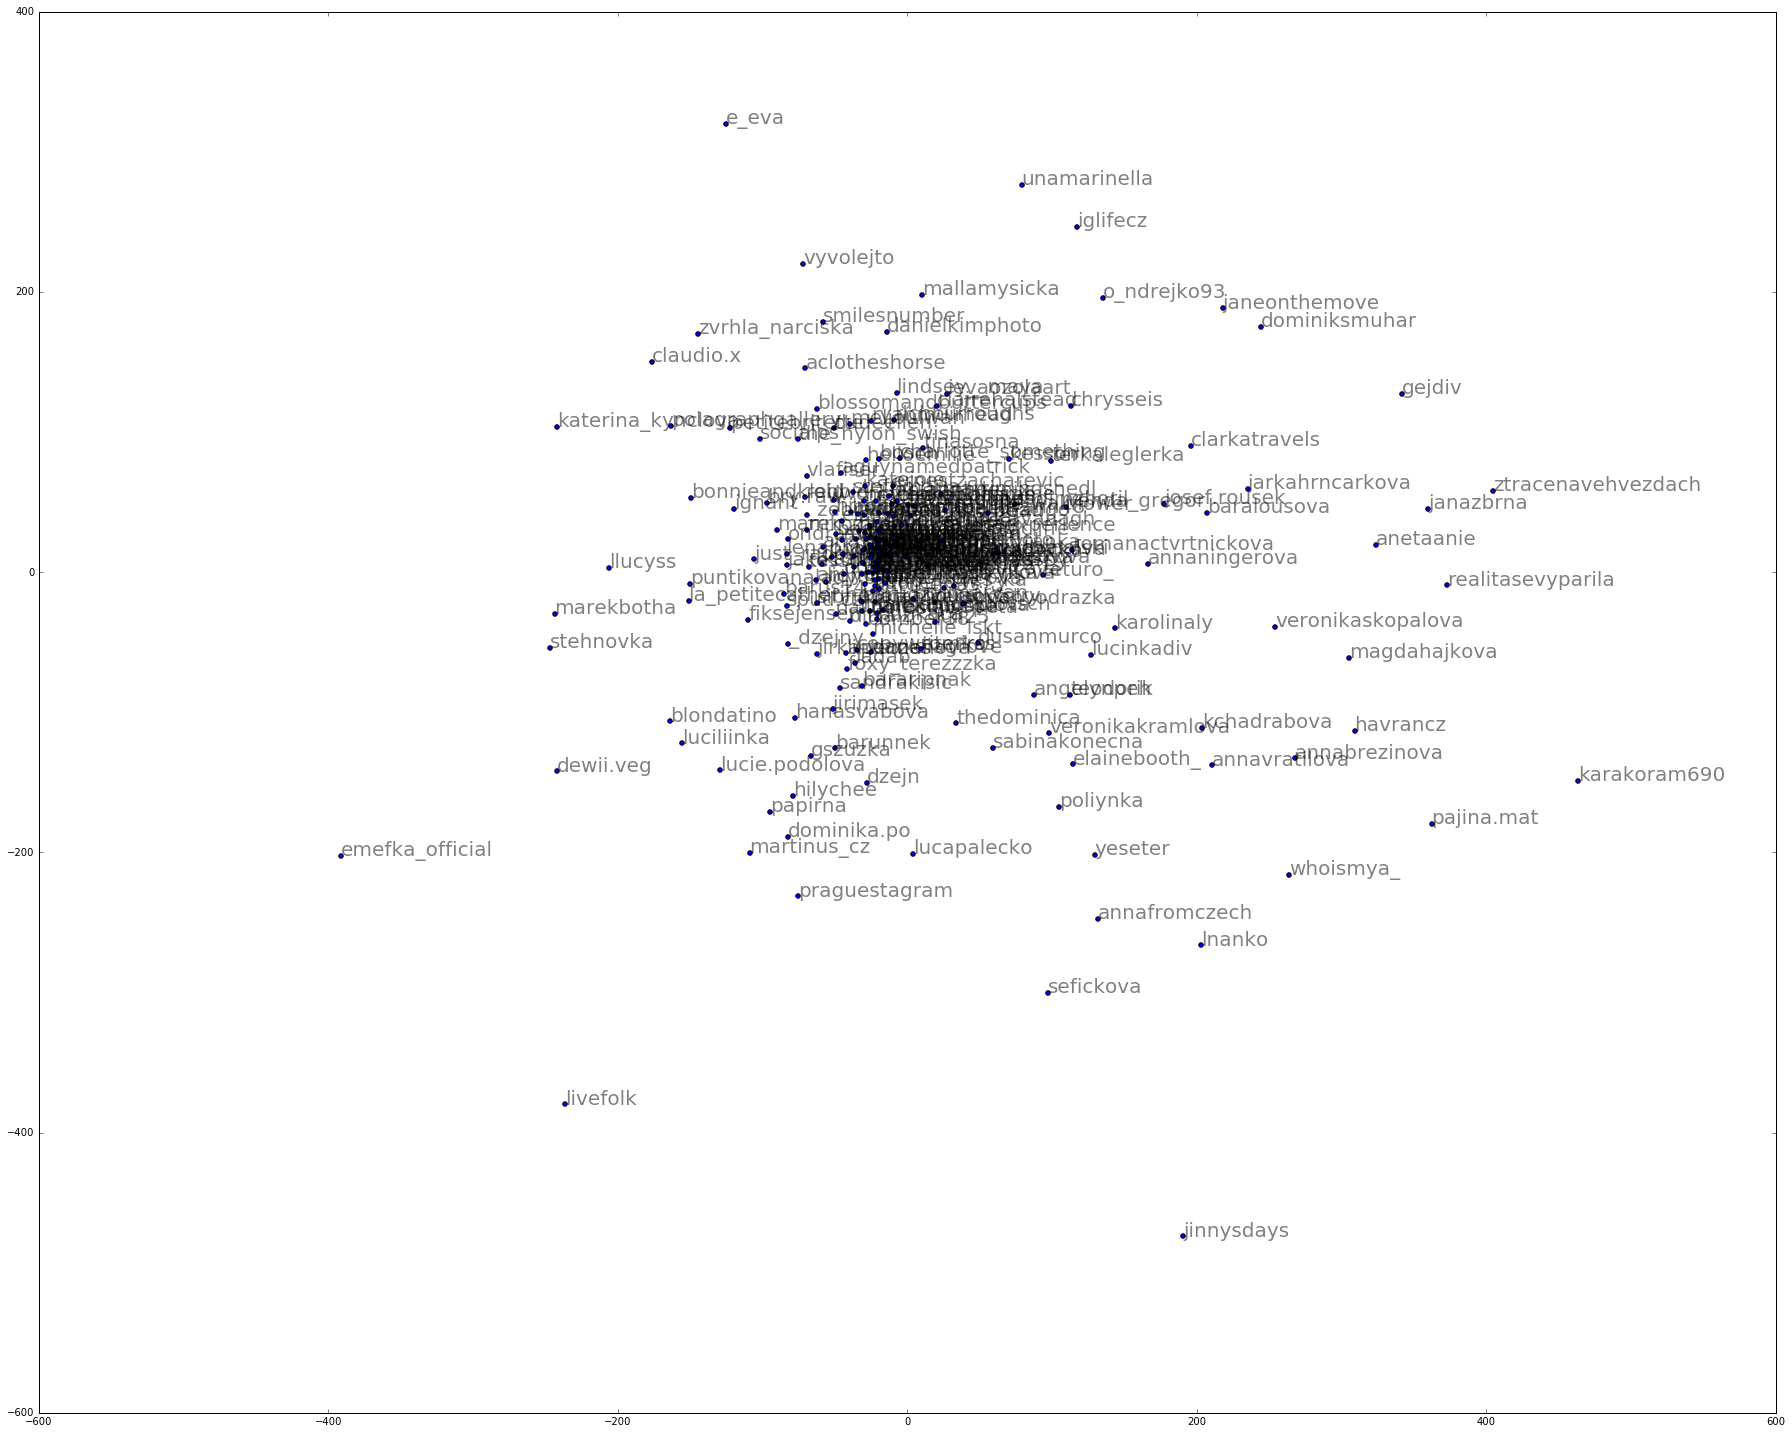

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from sklearn.metrics.pairwise import cosine_similarity

mds = MDS(n_components=2, dissimilarity="euclidean", random_state=1)
pos = mds.fit_transform(dtm)  # shape (n_components, n_samples)

plt.figure(figsize=(25, 20))  # use a bigger canvas than usual

xs, ys = pos[:, 0], pos[:, 1]


plt.scatter(xs, ys)

for x, y, name in zip(xs, ys, usernames):
    plt.text(x, y, name, alpha=0.5, fontsize=20)

plt.tight_layout()

### user distance

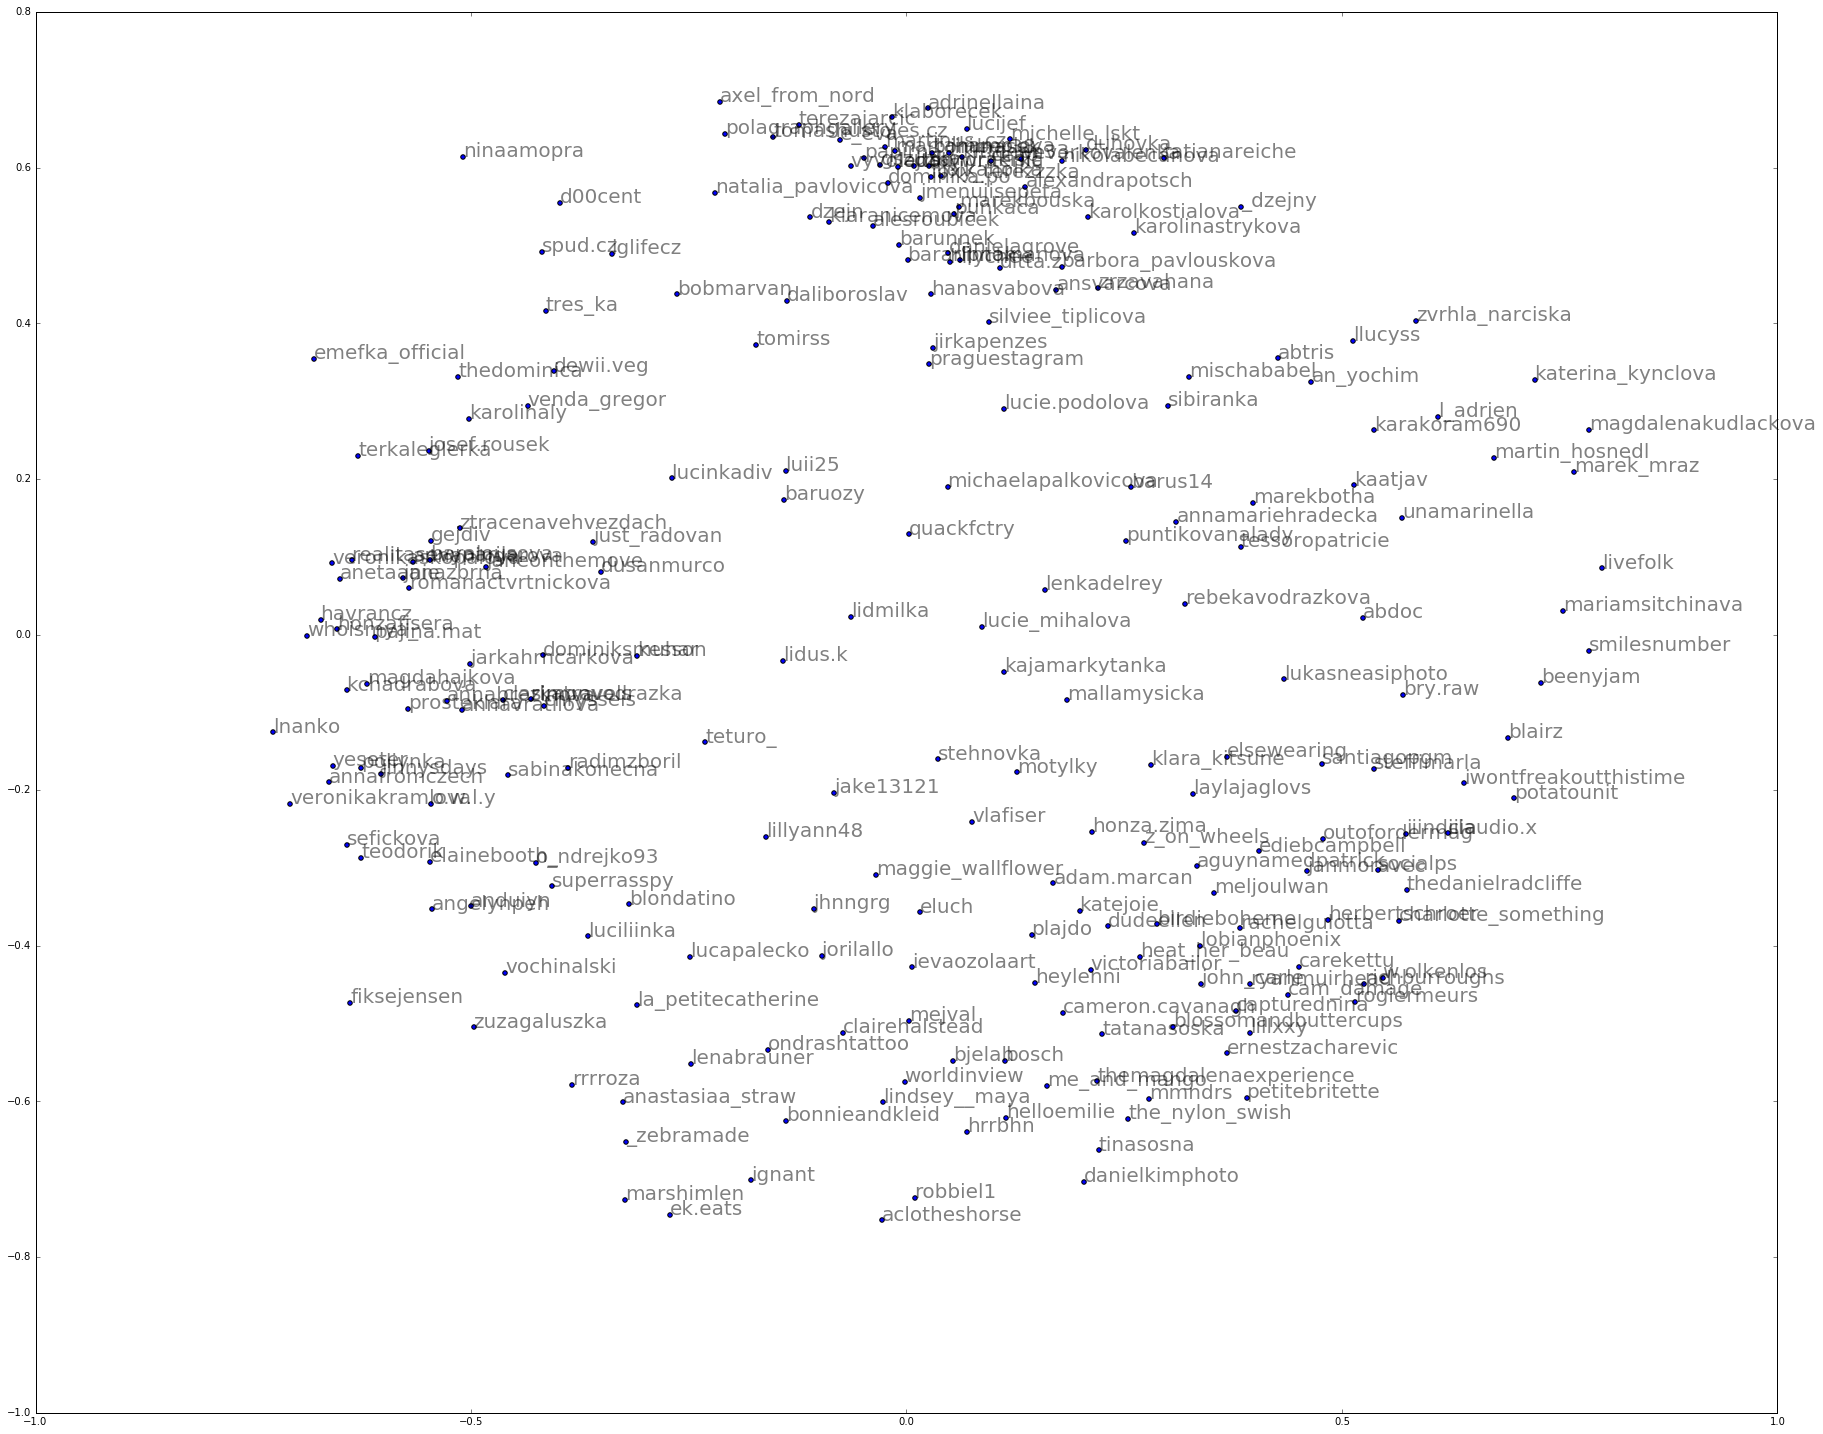

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from sklearn.metrics.pairwise import cosine_similarity

# we need distance, not similarity
dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)


plt.figure(figsize=(25, 20))  # use a bigger canvas than usual

xs, ys = pos[:, 0], pos[:, 1]


plt.scatter(xs, ys)

for x, y, name in zip(xs, ys, usernames):
    plt.text(x, y, name, alpha=0.5, fontsize=20)

plt.tight_layout()


### User distance between two users



In [5]:
from sklearn.metrics.pairwise import euclidean_distances

dist = euclidean_distances(dtm)

np.round(dist, 1)

array([[   0. ,  162. ,  239.4, ...,  166.3,  151.8,  427.6],
       [ 162. ,    0. ,  227.9, ...,  128.2,  104.9,  439.4],
       [ 239.4,  227.9,    0. , ...,  219. ,  208.6,  403.5],
       ..., 
       [ 166.3,  128.2,  219. , ...,    0. ,   67.4,  445.2],
       [ 151.8,  104.9,  208.6, ...,   67.4,    0. ,  441.2],
       [ 427.6,  439.4,  403.5, ...,  445.2,  441.2,    0. ]])

In [6]:
dist[usernames.index('josef.rousek'), usernames.index('emefka_official')]

431.84487955746334

In [7]:
dist[usernames.index('josef.rousek'), usernames.index('iglifecz')]

249.45941553687646

In [8]:
dist[usernames.index('josef.rousek'), usernames.index('motylky')]

217.82332290184172